# Regularizers as memory

_W. Evan Durno, 2022_

## Executive summary of current state 

Transfer learning, if properly realized, has the potential to move RL significantly closer to AGI. 
My current strategy to realize transfer learning is to mature our methods beyod _small learning rates_ and realize a 
mathemtically guaranteed optimum. To do this, I leverage the asymptotic equivalence of the MLE to the following.

$$ \hat \theta_{MLE} \to_{a.s.} \arg \max_\theta \frac{-1}{2} (\theta - \theta_0)^T \mathcal{I}_{\theta_0} (\theta - \theta_0) $$

With this information, we may pack all previously observed $n_1$ samples into this quadratic form regularizer 
centered around the $n_1^{th}$ estimate $\hat \theta_{n_1}$. 
Notice that the regularization term $\lambda$ is now exactly solvable.

$$ \hat \theta_{n_1+n_2} := \arg \max_\theta n_2^{-1} \sum_{i=n_1+1}^{n_1+n_2} \log f_X(X_i;\theta) - \frac{n_1}{2n_2} (\theta - \hat \theta_0)^T \hat{\mathcal{I}}_{\theta_0} (\theta - \hat \theta_0) $$

Seredipitously, this analytically-derived memory 
- is a regularizer with known $\lambda = n_1/n_2$,
- and a produces universal sufficient statistics for all models meeting a few regularity requirements. 

To contend with computationally intractibility of $\hat{\mathcal{I}}_{\theta_0}$, we apply a Krylov method, extending the Lanczos algorithm.

**CURRENT CHALLENGE:** reproducing results with more-complex models. I'm focussed on the CNN case. 

## impact

When combined with universal sufficient statistics, continuous transfer learning becomes particularly impactful. 
- My mathematically-guaranteed transfer learning mechanism leverages sufficient statistics to not require datasets to be distributed with models. 
Catestrophic forgetting can now be avoided merely by publishing sufficient statistics. 
- Packing arbitrarily large datasets into finite-dimensional sufficient statistics has a hardware _miniturization effect_, 
especially when combined with Krylov methods. 
Even if building a model requires an entire data center, it can be applied with significantly-less hardware. 
- Miniturization and sufficient statistics combine nicely to improve _RL in the real world_, 
because a data center may be leveraged to bootstrap a model into a near-real game. 
Then, agents can be deployed with miniturized models, making them effective with local compute. 
Further, because analytic memory is a regularizer, it'll maximize sampling efficiency by reducing the parameter space's effective dimension. 
For example, pick-and-place agents could be initialized digitally, then finished or forever-optimized 
with local compute on its small dataset of real-world observations. 

## analytic memory derivation 

Let our simple random sample have the following MLE.

$ \hat \theta = \arg \max_\theta \sum_{i=1}^n \log f_X(X_i; \theta) $ 

Break the sample into 2 parts, $n = n_1 + n_2$, where $n_1$ samples are to be memorized, and $n_2$ samples are new. 

$ = \arg \max_\theta \sum_{i=n_1+1}^{n_2} \log f_X(X_i; \theta) + \sum_{i=1}^{n_1} \log f_X(X_i; \theta) $

$ = \arg \max_\theta n_2^{-1} \sum_{i=n_1+1}^{n_2} \log f_X(X_i; \theta) + \frac{n_1}{n_1 n_2} \sum_{i=1}^{n_1} \log f_X(X_i; \theta) $

Expand the $n_1$ term with a Taylor series around $\theta_0$, so require $\theta$ near $\theta_0$. 

$ \approx \arg \max_\theta n_2^{-1} \sum_{i=n_1+1}^{n_2} \log f_X(X_i; \theta) + \frac{n_1}{n_1 n_2} \sum_{i=1}^{n_1} \log f_X(X_i; \theta_0) $
$ + \frac{n_1}{n_1 n_2} (\theta - \theta_0)^T \nabla_\theta \sum_{i=1}^{n_1} \log f_X(X_i; \theta_0) $ 
$ + \frac{n_1}{n_1 n_2} 2^{-1}(\theta - \theta_0)^T \nabla_\theta \nabla_\theta^T \sum_{i=1}^{n_1} \log f_X(X_i; \theta_0) (\theta - \theta_0) $ 

Apply the strong law of large numbers, so require $n_1$ large. 

$ \approx \arg \max_\theta n_2^{-1} \sum_{i=n_1+1}^{n_2} \log f_X(X_i; \theta) + \frac{n_1}{n_2} \mathbb{E} \log f_X(X_1; \theta_0) $
$ + \frac{n_1}{n_2} (\theta - \theta_0)^T \mathbb{E} \nabla_\theta \log f_X(X_1; \theta_0) $ 
$ + \frac{n_1}{n_2} 2^{-1}(\theta - \theta_0)^T \mathbb{E} \nabla_\theta \nabla_\theta^T \log f_X(X_1; \theta_0) (\theta - \theta_0) $

Set $\mathbb{E} \log f_X(X_1; \theta_0) = 0$ because it is constant under maximization over $\theta$, 
and recognize that $ \nabla_\theta \mathbb{E} \log f_X(X_1; \theta_0) = 0$. 

$ = \arg \max_\theta n_2^{-1} \sum_{i=n_1+1}^{n_2} \log f_X(X_i; \theta) $ 
$ + \frac{n_1}{n_2} 2^{-1}(\theta - \theta_0)^T \mathbb{E} \nabla_\theta \nabla_\theta^T \log f_X(X_1; \theta_0) (\theta - \theta_0) $

Recognize that $\mathbb{E} \nabla_\theta \nabla_\theta^T \log f_X(X_1; \theta_0) = -\mathcal{I}_{\theta_0}$. 

$ = \arg \max_\theta n_2^{-1} \sum_{i=n_1+1}^{n_2} \log f_X(X_i; \theta) $
$ - \frac{n_1}{2n_2} (\theta - \theta_0)^T \mathcal{I}_{\theta_0} (\theta - \theta_0) $

Substitute-in $\hat \theta_0 = \arg \max_\theta n_1^{-1} \sum_{i=1}^{n_1} \log f_X(X_i; \theta) $ for $\theta_0$. 
Fisher Information $\mathcal{I}_{\theta_0}$ can be estimated as an average $\hat{\mathcal{I}}_{\theta_0} = n_1^{-1} \sum_{i=1}^{n_1} G_i G_i^T$, 
where $\theta$-gradients $G_i := \nabla_\theta \log f_X(X_i; \theta) |_{\{ \theta = \theta_0 \}} $. 
So, $n_1$ must be sufficiently large that these approximations are accurate. 

$ = \arg \max_\theta n_2^{-1} \sum_{i=n_1+1}^{n_2} \log f_X(X_i; \theta) $
$ - \frac{n_1}{2n_2} (\theta - \theta_0)^T \hat{\mathcal{I}}_{\theta_0} (\theta - \theta_0) $

This completes our derivation. 

## computationally tractible estimation of $\mathcal{I}_\theta$

Production-quality deep learning models will have intractibly-large Fisher Information matrices. 
We'll use low rank approximation $AA^T \approx \mathcal{I}_\theta, A \in \mathbb{R}^{p \times r}$. 
I've modified a Krylov method to provide algorithmically-efficient updates to our approximation. 

See experiment 3 for details. 

### analytic memory enables universal sufficient statistics 

To understand why analytic memory "memorizes" the first $n_1$ samples, 
recognize that $\hat \theta$ is now approximately equal a function of $\left( \hat \theta_0, \hat{\mathcal{I}}_{\theta_0} \right)$ 
instead of $\left( X_1, X_2, \ldots, X_{n_1} \right)$.
Most-importantly $\left( \hat \theta_0, \hat{\mathcal{I}}_{\theta_0} \right)$ is of constant dimension, regardless of how big $n_1$ is. 

In this sense, $\left( \hat \theta_0, \hat{\mathcal{I}}_{\theta_0} \right)$ are sufficient statistics. 
More impactful, by applying asympotitic analysis, they are universal sufficient statistics for any model meeting a few regularity assumptions. 

## analytic memory is a regularizer

For log likelihood $f(X; \theta) = n^{-1}\sum \log f_X(X_i; \theta)$, 
we accept any $g(\theta)$ as a regularizer whenever the MLE utility function is a Langrangian as follows.

$$ \hat \theta = \arg \max_\theta f(X;\theta) - \lambda g(\theta) $$

Under this definition, our quadratic form $2^{-1}(\theta - \theta_0)^T \mathcal{I}_{\theta_0}(\theta - \theta_0)$ is a regularizer, 
with $\lambda = n_1/n_2$, and it applies parabolic geometric constraints. 

## transfer learning via continuous measure transformation 

This work doesn't just focus on RL because it is a good candidate for AGI, 
but also because RL illustrates continuous transformation of measures. 
Observe that an agent in a random environment decides an action at time $t$ due to its parameter $\hat \theta_t$. 
Then, because the agent continously updates its parameter, $\hat \theta_t$ randomly walks in $\Theta$, 
thereby causing $\mathbb{P}_{\hat \theta_t}$ to continuously and randomly transform in $t$. 
In this sense, any agent that successfully samples from $\mathbb{P}_{\hat \theta_1}$ to perform in $\mathbb{P}_{\hat \theta_2}$ 
is essentially performing _continuous transfer learning_. 
The success of RL thus far essentially proves, in theory, that continuity is an effective means of achieving transfer learning.
The only barrier to success is the cost of engineering sufficient continuity between games (measures).
Practically, games only need be _sufficient continuous_ to facilitate transition.
Understanding what "sufficient" means must be discovered through experimentation. 

Recognizing this observation denies stationarity of $\mathbb{P}_{\hat \theta_t}$ and thus simple random sample concepts.
So, the foundational statistical theory enabling all analysis is perhaps violated. 
However, RL has been effective for some time. 
So, I expect we are free to assume that $\mathbb{P}_{\hat \theta_t}$ can converge in $t$, parhaps falling into stationary attractors. 
So, this theory could be further-formalized to work with some $\mathbb{P}_{\hat \theta_t} = \mathbb{P} + \varepsilon_{\hat \theta_t}$ assumption. 
This theory is not built-out here. 


## experiment 1: Cartpole

We start with a _very_ simple example, proving-out concepts. 
The goal is to prove that $M$ provides a memory effect by detecting metric lift when the observation cache is cleared. 

For our first experiment, we run Cartpole for 1000 iterations, apply an experimental condition or 
control effect to the agent, then run for another 1000 iterations. Per condition, we track the cumulative score as our metric, 
resetting to zero upon game completions. The agent performs one optimizer update per iteration. 
Naturally, the metric has high-variance, so we use Databricks to execute 1000 experiments in parallel per condition, and average the metric.
Thus, the below-plotted metrics represent average score over time. 
The same agent is used up to the 1000 iterations before copying and applying effects, hence equivalent scores for the first half. 

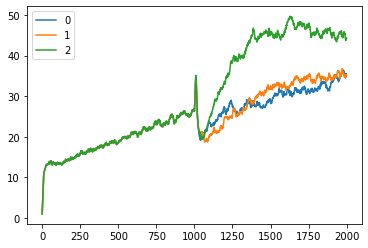

In [1]:
## DATA GENERATED WITH THIS CODE ON SPARK-K8S: https://github.com/wdurno/notebooks/blob/7dd506614aa8e4a506a19bc4179308136047005b/regularizers-as-memory/spark-k8s-experiment-1-and-2.py
## I FELT TOO CHEAP FOR DATABRICKS, SO I WROTE MY OWN: https://github.com/wdurno/spark-k8s

import pandas as pd 
import matplotlib.pyplot as plt 

df = pd.read_csv('data/df-experiment-1-2.zip') 
scores0 = df.scores0.tolist() 
scores1 = df.scores1.tolist() 
scores2 = df.scores2.tolist() 

plt.plot(scores0, label='0') ## control 0: use no memory, discard no observations 
plt.plot(scores1, label='1') ## control 1: use no memory, discard observations at iteration 1000 
plt.plot(scores2, label='2') ## experimental condition: use memory, discard observations at iteration 1000 
plt.legend() 
plt.show() 

### interpretation 

It is clear that the regularized memory term $M$ has provided significant metric lift. 
This in itself is obviously valuable and certainly still allows $M$ to apply a memory effect. 
However, a variety of concerns still stand.
- 1. Is this just the benefit of using a regularizer? Probably not, since we only have `[32, 32]` hidden nodes, but this must be tested.
- 2. 1000 iterations is very few. Does this have any benefit late-game? How about in more-complex games?
- 3. If we are observing memory, it is in the Fisher Information matrix, an asymptotic result representing no single observations but infinitely many. 
In what nuanced ways is this memory constrained? Is it similar to long-term memory, but not short-term? 
- 4. Exact Information matrices cannot be stored for large models due to their large $O(p^2)$ memory requirement. 
Can this method be made computationally feasible?

Prior to running this experiment, I expected the control to produce the highest scores at iteration 2000. 
I expect its lower performance is due to its observation cache being loaded with data generated by random play. 
It does make sense that it should out-perform condition 1 initially, but the poorer long-run performance was surprising.
This result illustrates the limited value of infinite memory. 

Immediately after iteration 1000, scores spike and fall together. 
I interpret this as a non-informative correlation, resulting from all agents starting new games simultaneously. 

## experiment 2: computational feasibility via low-rank approximations

The first concern we contend with is 4, computational feasibility. 
Usefully large models cannot use complete Fisher Information matrices, so we must experiment with approximations. 

We start by reducing the rank of the Information matrix by diagonalizing and only keeping the largest eigenvalues. 
Eigenvector and eigenvalue computation is still expensive, so this method will only prove feasibility without demonstrating a computational benefit. 

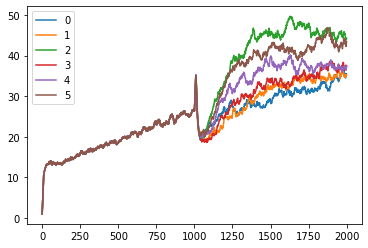

In [3]:
## DATA GENERATED WITH THIS CODE ON SPARK-K8S: https://github.com/wdurno/notebooks/blob/7dd506614aa8e4a506a19bc4179308136047005b/regularizers-as-memory/spark-k8s-experiment-1-and-2.py
## I FELT TOO CHEAP FOR DATABRICKS, SO I WROTE MY OWN: https://github.com/wdurno/spark-k8s

df = pd.read_csv('data/df-experiment-1-2.zip') 
scores0 = df.scores0.tolist() 
scores1 = df.scores1.tolist() 
scores2 = df.scores2.tolist() 
scores3 = df.scores3.tolist() 
scores4 = df.scores4.tolist() 
scores5 = df.scores5.tolist() 

plt.plot(scores0, label='0') ## control 0: use no memory, discard no observations 
plt.plot(scores1, label='1') ## control 1: use no memory, discard observations at iteration 1000 
plt.plot(scores2, label='2') ## experimental condition 1: use memory, discard observations at iteration 1000, use complete Hessian 
plt.plot(scores3, label='3') ## experimental condition 2: use memory, discard observations at iteration 1000, use 1 eigenvector to approximate the Hessian 
plt.plot(scores4, label='4') ## experimental condition 2: use memory, discard observations at iteration 1000, use 2 eigenvectors to approximate the Hessian 
plt.plot(scores5, label='5') ## experimental condition 2: use memory, discard observations at iteration 1000, use 10 eigenvectors to approximate the Hessian
plt.legend()
plt.show()

### interpretation 

We observe that it takes about 10 eigenvectors before lift is comparable to full-rank Fisher Information matrices. 
I'm not surprised to see that higher-ranked approximations provide better lift.
With evidence supporting the low-rank approach, it is time to test the effectiveness of a low-rank matrix approximation routine.

## experiment 3: computational feasibility

TODO I should actually cite work here 

For production models with $p$ parameters, $\mathcal{I}$ has $O(p^2)$ values, so cannot be stored. 
Nevertheless, we have good results with rank-reduced estimates, so will attempt to estimate $AA^T \approx \mathcal{I}$ for $A \in \mathbb{R}^{p \times r}$, 
where $r$ is significantly smaller than $p$. 
Most eigenpair algorithms are designed requiring all of $\mathcal{I}$ as input - we cannot do this, so have a challenge. 
Our only advantage is that we observe gradients $G_i \sim_{idd} N_p(0, \mathcal{I} )$. 

### estimating $\mathcal{I}$

Let us proceed by attempting estimation with the _Lanczos algorithm_, where we need not deal with $\mathcal{I}$, but only $\mathcal{I}v$. 
The Lanczos algorithm is a _Krylov_ method, built around _Krylov subspace_ $\text{span}\left\{ v, \mathcal{I}v, \mathcal{I}^2v, \ldots, \mathcal{I}^{r-1}v \right\}$.

The key observation is this: we can calculate the _Krylov vectors_ $v, \mathcal{I}v, \mathcal{I}^2v, \ldots, \mathcal{I}^{r-1}v$ with computational 
efficiency when using estimate $ \hat{\mathcal{I}}  = n^{-1}\sum_i^n G_i G_i^T$. With $G_i$ and $v$ in $\mathbb{R}^{p \times 1}$, 
we can expand recursively as follows...

$$ \hat{\mathcal{I}}^m v = \hat{\mathcal{I}}^{m-1} \left( \sum_i^n G_i G_i^T \right) v = \hat{\mathcal{I}}^{m-1} \left( \sum_i^n G_i G_i^Tv \right) $$

Notice how we now work with $O(nr)$ $O(p)$-time operations (totalling $O(nrp)$-time) and no $O(p^2)$-space operations. 
This is all possible because we only ever work with vector-vector operations, matrices are never used in forming the Krylov vectors. 
So, we should enjoy computational feasibility, if $nr$ is significantly smaller than $p^2$, which is expected in a deep learning context. 

### maintaining rank-reduction while combining rank-reduced estimates 

We may wish to re-memorize information, clearing an ever-growing observation cache as sampling continues. 
See experiment 8 for an example of this. 
Say we produce estimate $A_1 A_1^T$ at time step $t_1$ and $A_2 A_2^T$ at time step $t_2$. 
Notice that the naively combined estimate $A_1 A_1^T + A_2 A_2^T$ does not sustain its rank-reduced form, so violates our $O(p^2)$ space constraint. 
Fortunately, our Krylov estimation method can be slightly modified to maintain rank reduction. 

Calculate Krylov vectors $\{v, (A_1 A_1^T + A_2 A_2^T)v, (A_1 A_1^T + A_2 A_2^T)^2v, \ldots, (A_1 A_1^T + A_2 A_2^T)^{r-1}v \}$. 
Notice that, like above $(A_1 A_1^T + A_2 A_2^T)^{r-1}v = (A_1 A_1^T + A_2 A_2^T)^{r-2}(A_1 A_1^Tv + A_2 A_2^Tv)$, recursively. 
However, instead of vector-vector operations we have matrix-vector operations, but always with smaller $\mathbb{R}^{p \times r}$ matrices. 
So, each matrix-vector operation takes $O(rp)$ time, calculating all vectors takes $O(r^2p)$ time, and we observe our $O(p^2)$ space constraint. 

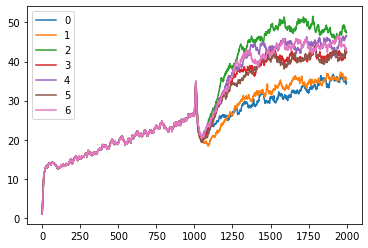

In [2]:
## DATA GENERATED WITH THIS CODE ON SPARK-K8S: https://github.com/wdurno/notebooks/blob/60aced4f32f049f1edcf4a1e497779d94cdef5b4/regularizers-as-memory/spark-k8s-experiment-3-comp-feasiblity.py
## I FELT TOO CHEAP FOR DATABRICKS, SO I WROTE MY OWN: https://github.com/wdurno/spark-k8s

import pandas as pd 
import matplotlib.pyplot as plt 

df = pd.read_csv('data/df-experiment-3.zip') 
scores0 = df.scores0.tolist() 
scores1 = df.scores1.tolist() 
scores2 = df.scores2.tolist() 
scores3 = df.scores3.tolist() 
scores4 = df.scores4.tolist() 
scores5 = df.scores5.tolist() 
scores6 = df.scores6.tolist() 

plt.plot(scores0, label='0') ## condition 0 (control): No use of memory, do not discard data 
plt.plot(scores1, label='1') ## condition 1 (control): No use of memory, do discard data 
plt.plot(scores2, label='2') ## condition 2 (control): Use memory, do discard data 
plt.plot(scores3, label='3') ## condition 3 (control): Use memory, do discard data, use a rank-5 eigen-approximation 
plt.plot(scores4, label='4') ## condition 4 (control): Use memory, do discard data, use a rank-10 eigen-approximation 
plt.plot(scores5, label='5') ## condition 5 (experimental): Use memory, do discard data, use a rank-5 Krylov approximation 
plt.plot(scores6, label='6') ## condition 6 (experimental): Use memory, do discard data, use a rank-10 Kyrlov approximation 
plt.legend()
plt.show()

### interpretation

The Krylov method produce results comparable to eigenvector rank reduction, but in $O(nrp)$ time - very powerful.
Further, the $O(p^2)$-space $\mathcal{I}$ need never be stored in memory, only the $O(rp)$-space rank-reduced estimate. 

## experiment 4: comparison with L2 regularization

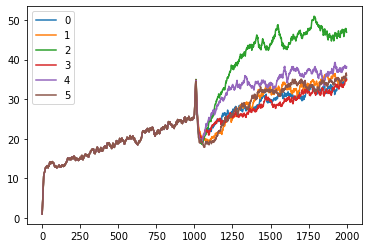

In [2]:
## DATA GENERATED WITH THIS CODE ON SPARK-K8S: https://github.com/wdurno/notebooks/blob/7dd506614aa8e4a506a19bc4179308136047005b/regularizers-as-memory/spark-k8s-experiment-4-l2-regularizer.py
## I FELT TOO CHEAP FOR DATABRICKS, SO I WROTE MY OWN: https://github.com/wdurno/spark-k8s

df = pd.read_csv('data/df-experiment-4.zip') 
scores0 = df.scores0.tolist() 
scores1 = df.scores1.tolist() 
scores2 = df.scores2.tolist() 
scores3 = df.scores3.tolist() 
scores4 = df.scores4.tolist() 
scores5 = df.scores5.tolist() 

plt.plot(scores0, label='0') ## No use of memory, no discarding of data 
plt.plot(scores1, label='1') ## No use of memory, do discard data 
plt.plot(scores2, label='2') ## Use memory, do discard data 
plt.plot(scores3, label='3') ## No use of memory, do not discard data, use L2 Regularizer = 1
plt.plot(scores4, label='4') ## No use of memory, do not discard data, use L2 Regularizer = 100
plt.plot(scores5, label='5') ## No use of memory, do discard data, use L2 Regularizer = 1 
plt.legend()
plt.show()

### interpretation 

TODO
- L2 under-performs but does add lift
- argue $M$ is actually an _optimal_ regularizer

## experiment 5: long games and convergence bahavior

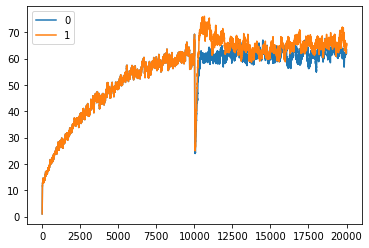

In [1]:
## DATA GENERATED WITH THIS CODE ON SPARK-K8S: ## https://github.com/wdurno/notebooks/blob/7dd506614aa8e4a506a19bc4179308136047005b/regularizers-as-memory/spark-k8s-experiment-5-long-games.py
## I FELT TOO CHEAP FOR DATABRICKS, SO I WROTE MY OWN: https://github.com/wdurno/spark-k8s

import pandas as pd 
import matplotlib.pyplot as plt 

df = pd.read_csv('data/df-experiment-5.zip') 
scores0 = df.scores0.tolist() 
scores1 = df.scores1.tolist() 

plt.plot(scores0, label='0') ## condition 0 (control), without application of memory and without discarding data
plt.plot(scores1, label='1') ## condition 1 (experimental): Use memory, discard data
plt.legend()
plt.show()

#### interpretation

- At optimal play, memory confers less benefit.

## experiment 6: optimal $\lambda$

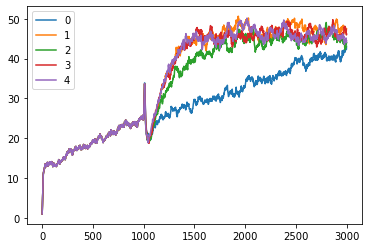

In [1]:
## DATA GENERATED WITH THIS CODE ON SPARK-K8S: ## https://github.com/wdurno/notebooks/blob/cd2f4a3d3fcb54f5a3ec834550889e717891cedd/regularizers-as-memory/spark-k8s-experiment-6-optimal-lambda.py 
## I FELT TOO CHEAP FOR DATABRICKS, SO I WROTE MY OWN: https://github.com/wdurno/spark-k8s

import pandas as pd 
import matplotlib.pyplot as plt 

df = pd.read_csv('data/df-experiment-6.zip') 
scores0 = df.scores0.tolist() 
scores1 = df.scores1.tolist() 
scores2 = df.scores2.tolist() 
scores3 = df.scores3.tolist() 
scores4 = df.scores4.tolist() 

plt.plot(scores0, label='0') ## condition 0 (control), without application of memory and without discarding data
plt.plot(scores1, label='1') ## condition 1 (control): Use memory, clear data, lambda = 1
plt.plot(scores2, label='2') ## condition 2 (experimental): Use memory, clear data, optimal lambda = n1/n2
plt.plot(scores3, label='3') ## condition 3 (experimental): Use memory, clear data, lambda = n1/(n1+n2)
plt.plot(scores4, label='4') ## condition 4 (experimental): Use memory, clear data, near-optimal lambda = min(1, n1/n2)
plt.legend()
plt.show()

### interpretation

- Optimal $\lambda$ performed produced less lift, perhaps due to over-parameterization. 
- Near-optimal $\lambda$ with numerical stabilizer performed better. 

## experiment 7: overcoming forgetting 

Demonstrating transfer learning is equivalent to overcoming catastrophic forgetting. 
Reinforcement learning games' sample space changes with gameplay, so are almost stationary. 
Therefore, any forgetting in RL is a poor illustration of catarophic forgetting. 
However, some forgetting should be possible. 

In this experiment, we test regularization-as-memory's ability to overcome this forgetting. 
We do so by re-running experiment 1, but with 10 times more samples, thereby increasing statistical power. 

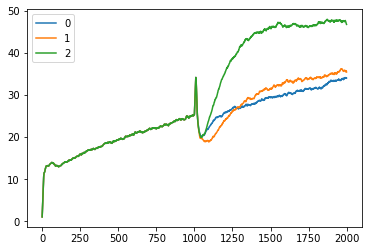

In [1]:
## DATA GENERATED WITH THIS CODE ON SPARK-K8S: https://github.com/wdurno/notebooks/blob/0add09936dd1261b79f19e6f3d0dd3c70b929f57/regularizers-as-memory/spark-k8s-experiment-7-forgetting.py 
## I FELT TOO CHEAP FOR DATABRICKS, SO I WROTE MY OWN: https://github.com/wdurno/spark-k8s

import pandas as pd 
import matplotlib.pyplot as plt 

df = pd.read_csv('data/df-experiment-7.zip') 
scores0 = df.scores0.tolist() 
scores1 = df.scores1.tolist() 
scores2 = df.scores2.tolist() 

plt.plot(scores0, label='0') ## condition 0 (control), without application of memory and without discarding data 
plt.plot(scores1, label='1') ## condition 1 (control): No use of memory, do discard data 
plt.plot(scores2, label='2') ## condition 2 (experimental): Use memory, do discard data  
plt.legend() 
plt.show() 

### interpretation 

- This is about the best result we could've hoped for. 
Condition 1 (no memory, data discarded) visibly drops below the control (condition 0). 
This illustrates forgetting. 
- It is interesting that condition 1 eventually out-performs condition 0. 
I expect this is due to 
  - the agent having to first re-make mistakes, 
  - but then eventually having an observation queue with overall-more-important data. 
- The analytic storage mechanism employed by regularization-as-memory (condition 2) out-performs other conditions impressively. 
I expect the benefit comes from
  - mistakes not having to be remade, 
  - and the standard dimensional-reduction benefits of a regularizer. 

Combining the observations of (1) forgetting indeed occurring, and (2) regularization-as-memory overcoming forgetting 
suggests it's time to scale-this-up to a more-important transfer learning context. 
Instead of transfer learning within a game, we should test transfer learning between similar games. 
If successful, no-stronger a result should be expected due to our foundational _almost-stationary_ assumption. 
Instead, the burden will fall upon AI developers to construct continuity in transfer learning contexts. 

## experiment 8: relearning

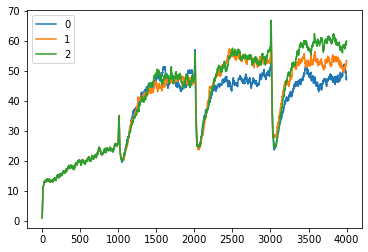

In [1]:
## DATA GENERATED WITH THIS CODE ON SPARK-K8S: https://github.com/wdurno/notebooks/blob/b3d82fad78355d5c8013d160a28018510f557bd1/regularizers-as-memory/spark-k8s-experiment-8-relearning.py
## I FELT TOO CHEAP FOR DATABRICKS, SO I WROTE MY OWN: https://github.com/wdurno/spark-k8s

import pandas as pd 
import matplotlib.pyplot as plt 

df = pd.read_csv('data/df-experiment-8.zip') 
scores0 = df.scores0.tolist() 
scores1 = df.scores1.tolist() 
scores2 = df.scores2.tolist() 

plt.plot(scores0, label='0') ## condition 0 (control) Use memory, do discard data, memorize once
plt.plot(scores1, label='1') ## condition 1 (experimental): Use memory, do dicard data, memorize twice
plt.plot(scores2, label='2') ## condition 2 (experimental): Use memory, do discard data, memorize thrice
plt.legend() 
plt.show() 

### interpretation 

Re-applying learning confers a significant benefit. 
I'll consider continuous learning first. 

## experiment 9: LSTM + CNN

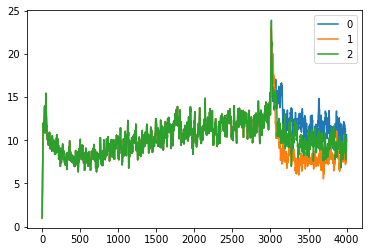

In [1]:
## DATA GENERATED WITH THIS CODE ON SPARK-K8S: TODO
## I FELT TOO CHEAP FOR DATABRICKS, SO I WROTE MY OWN: https://github.com/wdurno/spark-k8s 

import pandas as pd 
import matplotlib.pyplot as plt 

df = pd.read_csv('data/df-experiment-9.zip') 
scores0 = df.scores0.tolist() 
scores1 = df.scores1.tolist() 
scores2 = df.scores2.tolist() 

plt.plot(scores0, label='0') ## condition 0 (control): No use of memory, no discarding of data 
plt.plot(scores1, label='1') ## condition 1 (control): No use of memory, do discard data  
plt.plot(scores2, label='2') ## condition 2 (experimental): Use memory, do discard data  
plt.legend() 
plt.show() 

### interpretation

We have a negative result.
Given that
- this code is new, 
- and results have been good thus far, 

I expect there is a software bug.

## Scratch space

In [44]:
## Lanczos method sketch 
import numpy as np
from scipy.linalg import block_diag

A = np.random.rand(10, 3)
AAT = np.matmul(A, np.transpose(A)) 

v = np.random.rand(10,1) 
v = v / np.sqrt(np.matmul(np.transpose(v),v))

krylov = (v,
        np.matmul(np.linalg.matrix_power(AAT, 1), v),
        np.matmul(np.linalg.matrix_power(AAT, 2), v),
        np.matmul(np.linalg.matrix_power(AAT, 3), v))
K = np.concatenate(krylov, axis=1)
Q, R = np.linalg.qr(K) 

T = np.matmul(np.transpose(Q), AAT) 
T = np.matmul(T, Q) 
print('Example of tri-diagonal T:') 
print(T.round(2)) 

## Lanczos algorithm: produce AA^T = V T V^T
def lanczos(AAT, r): 
    vecs = [] 
    diags = [] 
    off_diags = [] 
    ## init 
    n = AAT.shape[0] 
    v = np.random.rand(n,1) 
    v = v / np.sqrt(np.matmul(np.transpose(v),v))
    next_v = np.matmul(AAT, v) 
    diag = np.matmul(np.transpose(next_v), v) 
    next_v = next_v - diag * v 
    vecs.append(v) 
    diags.append(diag) 
    for _ in range(r-1): 
        prev_v = v 
        off_diag = np.sqrt(np.matmul(np.transpose(next_v),next_v)) 
        v = next_v / off_diag  
        next_v = np.matmul(AAT, v) 
        diag = np.matmul(np.transpose(next_v), v) 
        next_v = next_v - diag * v - off_diag * prev_v 
        vecs.append(v) 
        diags.append(diag) 
        off_diags.append(off_diag) 
        pass 
    ## build it 
    V = np.concatenate(vecs, axis=1) 
    diags = np.array(diags).reshape([-1]) 
    off_diags = np.array(off_diags).reshape([-1]) 
    T = np.diag(diags) + np.diag(off_diags, -1) + np.diag(off_diags, 1) 
    VTVT = np.matmul(V, T)
    VTVT = np.matmul(VTVT, np.transpose(V)) 
    return VTVT 

errs = [np.sum(np.abs(AAT - lanczos(AAT, r))) for r in range(1, 5)] 
print('Demonstration of Lanczos convergence: ') 
print(f'errs: {errs}') 

## alternative covariance structure: block diagonal 
def build_block_cov(n, m, r=3):
    A1 = np.random.rand(n, r)
    A1 = np.matmul(A1, np.transpose(A1))
    A2 = np.random.rand(m, r)
    A2 = np.matmul(A2, np.transpose(A2))
    block_cov = block_diag(A1, A2)
    return block_cov 

block_cov = build_block_cov(60, 10)
errs = [np.sum(np.abs(block_cov - lanczos(block_cov, r))) for r in range(1,20)]
print('Block cov:') 
print(f'errs: {errs}') 

## alternative covariance structure: tri-diagonal 
def tri(n):
    diag = np.random.rand(n,1).reshape([-1]) + 1
    off_diag = np.random.rand(n-1, 1).reshape([-1])*2 - 1 
    t = np.diag(diag) + np.diag(off_diag, -1) + np.diag(off_diag, 1) 
    return t 

t = tri(20)
errs = [np.sum(np.abs(t - lanczos(t, r))) for r in range(1,17)]
print('tri-diag cov:')
print(f'errs: {errs}') 

## control statistics 
print(f'AAT abs sum: {np.sum(np.abs(AAT))}')
print(f'block_cov abs sum: {np.sum(np.abs(block_cov))}')
print(f'tri abs sum: {np.sum(np.abs(t))}')

Example of tri-diagonal T:
[[ 6.8  -4.26 -0.   -0.  ]
 [-4.26  3.11  0.62 -0.  ]
 [ 0.    0.62  1.2  -0.4 ]
 [-0.   -0.   -0.4   0.5 ]]
Demonstration of Lanczos convergence: 
errs: [52.111270907749415, 13.519392304288454, 3.0866806883951217, 6.311062783481702e-13]
Block cov:
errs: [2463.5097369929595, 539.9968762233913, 357.8758716115238, 224.64438043834875, 180.26488770976545, 9.583156626572073, 8.909754039423096e-07, 2679.2052871974647, 2770.134730946922, 2765.34023060262, 2752.9651088481255, 2755.5756852025715, 2751.5208409859333, 3371.254868786445, 5429.684945009714, 5503.664069120539, 5512.888105959733, 5501.194814174091, 8185.1428931865485]
tri-diag cov:
errs: [66.72809003481031, 71.98049762679008, 74.580733255979, 76.07038059819803, 75.77820786406107, 75.00728029377552, 71.04932418638604, 71.6668321272125, 68.20354520825916, 72.20320612942436, 73.11829356878377, 59.806764213546586, 56.09360373041497, 58.06149843201227, 52.742119531448665, 47.56582092024178]
AAT abs sum: 92.39507

In [14]:
### demonstrating analytic storage mechanism with Conv1Ds 

import torch
import torch.nn as nn 
import torch.optim as optim 
import pandas as pd 
from random import sample

channels = 5 
length = 10 
batch_size = 20 
C = torch.normal(1, torch.ones(channels, length)) 

def get_data(bias=1.):
    x = torch.normal(0, torch.ones(1, channels, length)) 
    y = x*C
    y = y.sum(dim=1).sum(dim=1)*(1. + 10./bias) + 2 ## bias simulates RL's non-stationarity 
    return x, y 

class Model(nn.Module): 
    def __init__(self): 
        super().__init__() 
        ## data structures 
        self.losses = [] 
        self.total_iters = 0 
        self.memory = [] 
        self.memory_matrix = None 
        self.memory_matrix_denominator = 0 
        ## params 
        self.conv1 = nn.Conv1d(channels, 5, kernel_size=3, stride=2) 
        self.conv1_bn =  nn.BatchNorm1d(5) 
        self.fc1 = nn.Linear(5*4, 1) 
        ## optim 
        self.optimizer = optim.Adam(self.parameters(), lr=0.001) 
        pass 
    
    def forward(self, x): 
        x = self.conv1(x) 
        x = self.conv1_bn(x) 
        x = torch.relu(x) 
        x = x.reshape([-1, 5*4]) 
        x = self.fc1(x) 
        return x 
    
    def optimize(self, batch_size=batch_size): 
        self.train() 
        if len(self.memory) < batch_size:
            return None 
        x, y = self.sample(batch_size=batch_size) 
        self.zero_grad() 
        yy = self.forward(x) 
        loss = nn.MSELoss() 
        loss = loss(y.reshape([-1]), yy.reshape([-1]))
        if self.memory_matrix is not None: 
            p = nn.utils.parameters_to_vector(self.parameters()).reshape([-1, 1]) 
            p0 = self.parameter_center 
            regularizer = (p - p0).transpose(0, 1).matmul(batch_size* self.memory_matrix / self.memory_matrix_denominator).matmul(p - p0) 
            regularizer = regularizer.reshape([]) 
            loss += regularizer 
        _loss = float(loss) 
        self.losses.append(_loss) 
        loss.backward() 
        self.optimizer.step() 
        pass
    
    def sample(self, batch_size=batch_size): 
        x_tensor_list = [] 
        y_tensor_list = [] 
        batch = sample(self.memory, batch_size)  
        for x, y in batch: 
            x_tensor_list.append(x) 
            y_tensor_list.append(y) 
            pass 
        x = torch.cat(x_tensor_list) 
        y = torch.cat(y_tensor_list) 
        return x, y 

    def simulate(self, n_iters=batch_size+5): 
        for _ in range(n_iters): 
            self.total_iters += 1 
            ## real RL would require model evaluations here 
            x, y = get_data(bias=self.total_iters) 
            self.memory.append((x,y)) 
            self.optimize(batch_size=batch_size) 
            pass 
        pass 

    def memorize(self): 
        self.eval() 
        for x,y in self.memory: 
            self.zero_grad() 
            yy = self.forward(x) 
            loss = nn.MSELoss() 
            loss = loss(y.reshape([-1]), yy.reshape([-1])) 
            loss.backward() 
            grad = torch.cat([p.grad.reshape([-1]) for p in self.parameters()]).reshape([-1, 1]) 
            if self.memory_matrix is None: 
                self.memory_matrix = 0. 
                pass 
            self.memory_matrix += grad.matmul(grad.transpose(0, 1)) 
            self.memory_matrix_denominator += 1 
            pass 
        self.memory = [] 
        self.parameter_center = nn.utils.parameters_to_vector(self.parameters()).detach().reshape([-1, 1]) 
        pass 
    pass 

def experiment(memorize=True): 
    m = Model() 
    m.simulate() 
    if memorize: 
        m.memorize() 
    m.simulate() 
    return m.losses 

def avg_experiments(n=10, memorize=True): 
    results = {} 
    for i in range(n): 
        results[i] = experiment(memorize=memorize) 
        pass 
    df = pd.DataFrame(results) 
    return df.mean(axis=1).tolist() 

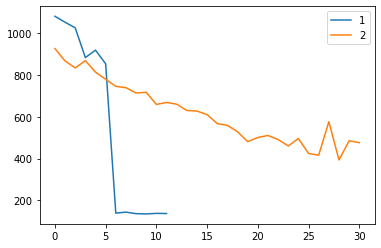

In [16]:
import matplotlib.pyplot as plt 

memorized_losses = avg_experiments(n=100, memorize=True) 
not_memorized_losses = avg_experiments(n=100, memorize=False) 

plt.plot(memorized_losses, label='1') 
plt.plot(not_memorized_losses, label='2') 
plt.legend() 
plt.show() 

In [13]:
### demonstrating analytic storage mechanism with Conv2Ds 

import torch
import torch.nn as nn 
import torch.optim as optim 
import pandas as pd 
from random import sample

channels = 5 
length = 10 
batch_size = 20 
C = torch.normal(1, torch.ones(channels, length, length)) 

def get_data(bias=1.):
    x = torch.normal(0, torch.ones(1, channels, length, length)) 
    y = x*C
    y = y.sum(dim=1).sum(dim=1).sum(dim=1)*(1. + 10./bias) + 2 ## bias simulates RL's non-stationarity 
    return x, y 

class Model(nn.Module): 
    def __init__(self): 
        super().__init__() 
        ## data structures 
        self.losses = [] 
        self.total_iters = 0 
        self.memory = [] 
        self.memory_matrix = None 
        self.memory_matrix_denominator = 0 
        ## params 
        self.conv1 = nn.Conv2d(channels, 5, kernel_size=3, stride=2) 
        self.conv1_bn =  nn.BatchNorm2d(5) 
        self.fc1 = nn.Linear(5*4*4, 1) 
        ## optim 
        self.optimizer = optim.Adam(self.parameters(), lr=0.001) 
        pass 
    
    def forward(self, x): 
        x = self.conv1(x) 
        x = self.conv1_bn(x) 
        x = torch.relu(x) 
        x = x.reshape([-1, 5*4*4]) 
        x = self.fc1(x) 
        return x 
    
    def optimize(self, batch_size=batch_size): 
        self.train() 
        if len(self.memory) < batch_size:
            return None 
        x, y = self.sample(batch_size=batch_size) 
        self.zero_grad() 
        yy = self.forward(x) 
        loss = nn.MSELoss() 
        loss = loss(y.reshape([-1]), yy.reshape([-1]))
        if self.memory_matrix is not None: 
            p = nn.utils.parameters_to_vector(self.parameters()).reshape([-1, 1]) 
            p0 = self.parameter_center 
            regularizer = (p - p0).transpose(0, 1).matmul(batch_size* self.memory_matrix / self.memory_matrix_denominator).matmul(p - p0) 
            regularizer = regularizer.reshape([]) 
            loss += regularizer 
        _loss = float(loss) 
        self.losses.append(_loss) 
        loss.backward() 
        self.optimizer.step() 
        pass
    
    def sample(self, batch_size=batch_size): 
        x_tensor_list = [] 
        y_tensor_list = [] 
        batch = sample(self.memory, batch_size)  
        for x, y in batch: 
            x_tensor_list.append(x) 
            y_tensor_list.append(y) 
            pass 
        x = torch.cat(x_tensor_list) 
        y = torch.cat(y_tensor_list) 
        return x, y 

    def simulate(self, n_iters=batch_size+5): 
        for _ in range(n_iters): 
            self.total_iters += 1 
            ## real RL would require model evaluations here 
            x, y = get_data(bias=self.total_iters) 
            self.memory.append((x,y)) 
            self.optimize(batch_size=batch_size) 
            pass 
        pass 

    def memorize(self): 
        self.eval() 
        for x,y in self.memory: 
            self.zero_grad() 
            yy = self.forward(x) 
            loss = nn.MSELoss() 
            loss = loss(y.reshape([-1]), yy.reshape([-1])) 
            loss.backward() 
            grad = torch.cat([p.grad.reshape([-1]) for p in self.parameters()]).reshape([-1, 1]) 
            if self.memory_matrix is None: 
                self.memory_matrix = 0. 
                pass 
            self.memory_matrix += grad.matmul(grad.transpose(0, 1)) 
            self.memory_matrix_denominator += 1 
            pass 
        self.memory = [] 
        self.parameter_center = nn.utils.parameters_to_vector(self.parameters()).detach().reshape([-1, 1]) 
        pass 
    pass 

def experiment(memorize=True): 
    m = Model() 
    m.simulate() 
    if memorize: 
        m.memorize() 
    m.simulate() 
    return m.losses 

def avg_experiments(n=10, memorize=True): 
    results = {} 
    for i in range(n): 
        results[i] = experiment(memorize=memorize) 
        pass 
    df = pd.DataFrame(results) 
    return df.mean(axis=1).tolist() 

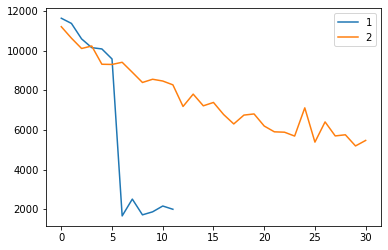

In [14]:
import matplotlib.pyplot as plt 

memorized_losses = avg_experiments(n=100, memorize=True) 
not_memorized_losses = avg_experiments(n=100, memorize=False) 

plt.plot(memorized_losses, label='1') 
plt.plot(not_memorized_losses, label='2') 
plt.legend() 
plt.show() 

In [15]:
## Illustrating why this method is only useful when sampling is expensive 
## sample size increased from 1 to 30 
import torch
import torch.nn as nn 
import torch.optim as optim 
import pandas as pd 
from random import sample

channels = 5 
length = 10 
batch_size = 20 
C = torch.normal(1, torch.ones(channels, length, length)) 

def get_data(bias=1.):
    x = torch.normal(0, torch.ones(30, channels, length, length)) 
    y = x*C
    y = y.sum(dim=1).sum(dim=1).sum(dim=1)*(1. + 10./bias) + 2 ## bias simulates RL's non-stationarity 
    return x, y 

class Model(nn.Module): 
    def __init__(self): 
        super().__init__() 
        ## data structures 
        self.losses = [] 
        self.total_iters = 0 
        self.memory = [] 
        self.memory_matrix = None 
        self.memory_matrix_denominator = 0 
        ## params 
        self.conv1 = nn.Conv2d(channels, 5, kernel_size=3, stride=2) 
        self.conv1_bn =  nn.BatchNorm2d(5) 
        self.fc1 = nn.Linear(5*4*4, 1) 
        ## optim 
        self.optimizer = optim.Adam(self.parameters(), lr=0.001) 
        pass 
    
    def forward(self, x): 
        x = self.conv1(x) 
        x = self.conv1_bn(x) 
        x = torch.relu(x) 
        x = x.reshape([-1, 5*4*4]) 
        x = self.fc1(x) 
        return x 
    
    def optimize(self, batch_size=batch_size): 
        self.train() 
        if len(self.memory) < batch_size:
            return None 
        x, y = self.sample(batch_size=batch_size) 
        self.zero_grad() 
        yy = self.forward(x) 
        loss = nn.MSELoss() 
        loss = loss(y.reshape([-1]), yy.reshape([-1]))
        if self.memory_matrix is not None: 
            p = nn.utils.parameters_to_vector(self.parameters()).reshape([-1, 1]) 
            p0 = self.parameter_center 
            regularizer = (p - p0).transpose(0, 1).matmul(batch_size* self.memory_matrix / self.memory_matrix_denominator).matmul(p - p0) 
            regularizer = regularizer.reshape([]) 
            loss += regularizer 
        _loss = float(loss) 
        self.losses.append(_loss) 
        loss.backward() 
        self.optimizer.step() 
        pass
    
    def sample(self, batch_size=batch_size): 
        x_tensor_list = [] 
        y_tensor_list = [] 
        batch = sample(self.memory, batch_size)  
        for x, y in batch: 
            x_tensor_list.append(x) 
            y_tensor_list.append(y) 
            pass 
        x = torch.cat(x_tensor_list) 
        y = torch.cat(y_tensor_list) 
        return x, y 

    def simulate(self, n_iters=batch_size+5): 
        for _ in range(n_iters): 
            self.total_iters += 1 
            ## real RL would require model evaluations here 
            x, y = get_data(bias=self.total_iters) 
            self.memory.append((x,y)) 
            self.optimize(batch_size=batch_size) 
            pass 
        pass 

    def memorize(self): 
        self.eval() 
        for x,y in self.memory: 
            self.zero_grad() 
            yy = self.forward(x) 
            loss = nn.MSELoss() 
            loss = loss(y.reshape([-1]), yy.reshape([-1])) 
            loss.backward() 
            grad = torch.cat([p.grad.reshape([-1]) for p in self.parameters()]).reshape([-1, 1]) 
            if self.memory_matrix is None: 
                self.memory_matrix = 0. 
                pass 
            self.memory_matrix += grad.matmul(grad.transpose(0, 1)) 
            self.memory_matrix_denominator += 1 
            pass 
        self.memory = [] 
        self.parameter_center = nn.utils.parameters_to_vector(self.parameters()).detach().reshape([-1, 1]) 
        pass 
    pass 

def experiment(memorize=True): 
    m = Model() 
    m.simulate() 
    if memorize: 
        m.memorize() 
    m.simulate() 
    return m.losses 

def avg_experiments(n=10, memorize=True): 
    results = {} 
    for i in range(n): 
        results[i] = experiment(memorize=memorize) 
        pass 
    df = pd.DataFrame(results) 
    return df.mean(axis=1).tolist() 

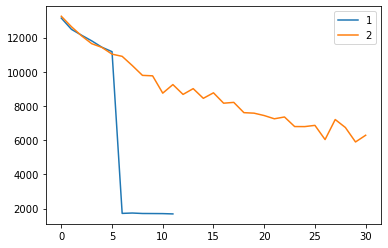

In [16]:
import matplotlib.pyplot as plt 

memorized_losses = avg_experiments(n=100, memorize=True) 
not_memorized_losses = avg_experiments(n=100, memorize=False) 

plt.plot(memorized_losses, label='1') 
plt.plot(not_memorized_losses, label='2') 
plt.legend() 
plt.show() 

In [6]:
import torch

x = torch.tensor([i for i in range(3*3*3)]).reshape([3,3,3])
print(x) 
y = torch.unbind(x)
print(y) 
y = torch.stack(y) 
print(x - y)

tensor([[[ 0,  1,  2],
         [ 3,  4,  5],
         [ 6,  7,  8]],

        [[ 9, 10, 11],
         [12, 13, 14],
         [15, 16, 17]],

        [[18, 19, 20],
         [21, 22, 23],
         [24, 25, 26]]])
(tensor([[0, 1, 2],
        [3, 4, 5],
        [6, 7, 8]]), tensor([[ 9, 10, 11],
        [12, 13, 14],
        [15, 16, 17]]), tensor([[18, 19, 20],
        [21, 22, 23],
        [24, 25, 26]]))
tensor([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]])


In [7]:
## 2D CNN models misbehaving... debugging here 

from regmem_cnn import Model 
m = Model() 
m.simulate(total_iters=1000, plot_rewards=True) 

ImportError: 
    Error occurred while running `from pyglet.gl import *`
    HINT: make sure you have OpenGL install. On Ubuntu, you can run 'apt-get install python-opengl'.
    If you're running on a server, you may need a virtual frame buffer; something like this should work:
    'xvfb-run -s "-screen 0 1400x900x24" python <your_script.py>'
    

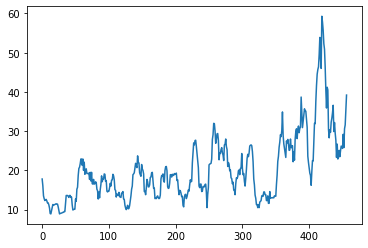

In [1]:
x = [33.0, 49.0, 18.0, 13.0, 9.0, 8.0, 13.0, 12.0, 9.0, 14.0, 16.0, 23.0, 11.0, 8.0, 11.0, 9.0, 9.0, 7.0, 9.0, 9.0, 8.0, 9.0, 10.0, 16.0, 18.0, 18.0, 8.0, 7.0, 10.0, 10.0, 9.0, 8.0, 10.0, 9.0, 9.0, 9.0, 9.0, 8.0, 10.0, 11.0, 10.0, 8.0, 12.0, 9.0, 29.0, 30.0, 9.0, 8.0, 8.0, 8.0, 15.0, 8.0, 7.0, 10.0, 9.0, 17.0, 10.0, 9.0, 8.0, 34.0, 9.0, 39.0, 12.0, 40.0, 27.0, 20.0, 19.0, 21.0, 8.0, 18.0, 25.0, 10.0, 33.0, 9.0, 37.0, 24.0, 7.0, 21.0, 8.0, 19.0, 9.0, 28.0, 11.0, 31.0, 8.0, 23.0, 19.0, 9.0, 9.0, 24.0, 7.0, 11.0, 7.0, 10.0, 26.0, 8.0, 40.0, 22.0, 31.0, 9.0, 15.0, 10.0, 20.0, 9.0, 8.0, 10.0, 13.0, 20.0, 33.0, 9.0, 24.0, 21.0, 13.0, 24.0, 9.0, 24.0, 9.0, 10.0, 8.0, 7.0, 7.0, 29.0, 10.0, 23.0, 17.0, 13.0, 8.0, 9.0, 19.0, 7.0, 11.0, 10.0, 9.0, 8.0, 10.0, 9.0, 13.0, 15.0, 10.0, 8.0, 18.0, 22.0, 22.0, 25.0, 18.0, 38.0, 15.0, 18.0, 23.0, 19.0, 11.0, 18.0, 52.0, 8.0, 17.0, 13.0, 10.0, 14.0, 53.0, 8.0, 7.0, 9.0, 7.0, 9.0, 8.0, 30.0, 32.0, 8.0, 40.0, 8.0, 12.0, 28.0, 8.0, 20.0, 9.0, 9.0, 12.0, 9.0, 13.0, 9.0, 11.0, 33.0, 10.0, 15.0, 7.0, 10.0, 20.0, 50.0, 22.0, 8.0, 16.0, 15.0, 7.0, 45.0, 16.0, 11.0, 9.0, 9.0, 18.0, 9.0, 28.0, 37.0, 7.0, 39.0, 23.0, 9.0, 8.0, 14.0, 16.0, 10.0, 30.0, 18.0, 9.0, 17.0, 7.0, 20.0, 7.0, 8.0, 7.0, 11.0, 7.0, 14.0, 33.0, 24.0, 8.0, 9.0, 12.0, 16.0, 16.0, 8.0, 23.0, 27.0, 28.0, 25.0, 55.0, 33.0, 39.0, 11.0, 27.0, 9.0, 7.0, 8.0, 9.0, 9.0, 8.0, 29.0, 48.0, 11.0, 8.0, 10.0, 19.0, 8.0, 8.0, 15.0, 9.0, 8.0, 9.0, 44.0, 26.0, 68.0, 21.0, 9.0, 9.0, 26.0, 59.0, 20.0, 38.0, 43.0, 8.0, 36.0, 31.0, 23.0, 10.0, 9.0, 9.0, 38.0, 36.0, 53.0, 13.0, 23.0, 25.0, 9.0, 50.0, 10.0, 23.0, 19.0, 28.0, 10.0, 23.0, 19.0, 8.0, 11.0, 30.0, 8.0, 10.0, 23.0, 8.0, 10.0, 11.0, 46.0, 24.0, 9.0, 35.0, 23.0, 12.0, 11.0, 24.0, 11.0, 48.0, 8.0, 8.0, 12.0, 15.0, 11.0, 31.0, 34.0, 52.0, 22.0, 42.0, 17.0, 26.0, 14.0, 16.0, 9.0, 16.0, 8.0, 8.0, 7.0, 16.0, 9.0, 10.0, 14.0, 8.0, 16.0, 9.0, 22.0, 10.0, 9.0, 28.0, 10.0, 8.0, 25.0, 8.0, 9.0, 9.0, 7.0, 10.0, 21.0, 9.0, 10.0, 38.0, 8.0, 9.0, 9.0, 9.0, 8.0, 9.0, 26.0, 9.0, 9.0, 68.0, 32.0, 44.0, 22.0, 32.0, 21.0, 28.0, 21.0, 24.0, 57.0, 9.0, 10.0, 32.0, 9.0, 22.0, 63.0, 23.0, 30.0, 12.0, 41.0, 10.0, 38.0, 10.0, 9.0, 27.0, 22.0, 49.0, 8.0, 65.0, 61.0, 17.0, 13.0, 33.0, 18.0, 10.0, 33.0, 52.0, 85.0, 26.0, 22.0, 33.0, 29.0, 49.0, 12.0, 10.0, 13.0, 31.0, 11.0, 10.0, 9.0, 19.0, 23.0, 24.0, 47.0, 38.0, 12.0, 82.0, 56.0, 9.0, 66.0, 59.0, 52.0, 36.0, 54.0, 69.0, 56.0, 27.0, 32.0, 142.0, 51.0, 38.0, 18.0, 22.0, 9.0, 10.0, 10.0, 80.0, 25.0, 41.0, 30.0, 59.0, 11.0, 48.0, 19.0, 24.0, 29.0, 13.0, 48.0, 14.0, 12.0, 15.0, 45.0, 10.0, 24.0, 41.0, 13.0, 28.0, 60.0, 11.0, 9.0, 51.0, 11.0, 58.0, 34.0, 81.0, 49.0]
import matplotlib.pyplot as plt 
import numpy as np
N = 10
y = np.convolve(x, np.ones(N)/N, mode='valid')
plt.plot(y) 
plt.show()

## RL-reweighted (RLR) estimates 

This first estimate is designed to improve efficiency of sampling in reinforcement learning (RL) by 
up-weighting more-important observations. We'll use this estimate:

$$ \hat \theta_{RLR} = \hat \theta_{n_1+n_2} = \text{arg max}_\theta \left( \sum_{i=1}^{n_1+n_2} \| \hat r_i \|_2^{2b} \right)^{-1} \left( \sum_{i=n_1+1}^{n_1+n_2} \| \hat r_i \|_2^{2b} \log f_X(X_i; \theta) - \sum_{i=1}^{n_1} \frac{\lambda}{2} (\theta - \hat \theta_{n_1+n_2-1})^T H_i (\theta - \hat \theta_{n_1+n_2-1}) \right) $$

where 
- $n_1$ is the number of priviously observed sameples, 
- $n_2$ is the number of newly observed samples, 
- $\hat r_i$ is the estimated reward for observation $i$, 
- $b > 0$ is a bias term,  
- $H_i = \| \hat r_i \|^{2b}_2 \left( \nabla_\theta \log f_X(X_j; \theta)|_{\theta = \hat \theta_{j-1}} \right) \left( \nabla_\theta \log f_X(X_j; \theta)|_{\theta = \hat \theta_{j-1}} \right)^T$ is a Hessian approximation, and
- $\hat \theta_0$ is an initial estimate guess, commonly required in optimization routines. 

Define $ M:= \sum_{i=1}^{n_1}(\theta - \theta_{n_1+n_2-1})^TH_i(\theta - \theta_{n_1+n_2-1})$, which we'll refer to as the "memory term". 
The key heuristic is that $M$, a quadratic regularizer, approximates large-sample likelihoods under maximization. 
This insight can be seen through a Taylor approximation near true $\theta$, designated $\theta_T$.

$\hat \theta_{MLE} = \text{arg max}_\theta n^{-1} \sum_{i=1}^n \log f_X(X_i;\theta) $

$ \approx \text{arg max}_\theta n^{-1}\sum_i \log f_X(X_i; \theta_T) + n^{-1}\sum_i (\theta - \theta_T)^T \nabla_\theta \log f_X(X_i; \theta_T) + n^{-1}2^{-1} \sum_i (\theta - \theta_T)^T (\nabla_\theta^2 \log f_X(X_i; \theta_T))(\theta - \theta_T) $

$ \approx \text{arg max}_\theta n^{-1}\sum_i \log f_X(X_i; \theta_T) + 0 + n^{-1}2^{-1} \sum_i (\theta - \theta_T)^T (\nabla_\theta^2 \log f_X(X_i; \theta_T))(\theta - \theta_T) $

$ \approx \text{arg max}_\theta n^{-1}2^{-1} \sum_i (\theta - \theta_T)^T (\nabla_\theta^2 \log f_X(X_i; \theta_T))(\theta - \theta_T) $

This work basically tests the quality of our $M \approx \sum_i (\theta - \theta_T)^T (\nabla_\theta)^2 \log f_X(X_i; \theta_T)(\theta - \theta_T) $ heuristic.
If true, then we should see that the quadratic regularizer, $M$, affects memory through geometric constraints on the estimator.

Later, we'll experiment with recency bias and rank reductions for $M$.

Notice that $\hat \theta_{RLR}$ is asymptotically equivalent to a redistributed sampling, 
with more observations when they are more important. 
Hence, the essence of this computational efficiency strategy is to 
- add frequency bias to important observations, 
- and preserve their information via geometric estimator constraints.

torch.Size([60, 40])


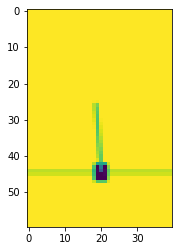

In [18]:
import pickle
import torch
import numpy as np
from matplotlib import pyplot as plt

with open('data/images.pkl', 'rb') as f:
    x = pickle.load(f) 
    pass 

y = x[29]
#y = np.mean(y, axis=2) 
#y = y.astype('int32') 

#y = torch.tensor(y).reshape([1, 40, 60, 3]).permute(0, 3, 1, 2) 
y = torch.tensor(y).unsqueeze(dim=0).permute(0, 3, 1, 2) 
y = (y*1.).mean(dim=1)[0,:,:] 
print(y.shape)
y = y.numpy().astype('int32')

plt.imshow(y, interpolation='nearest') 
plt.show()

#z = x[25][0, :, :, :]
#y = ((z+.5)*255) 
##y = y.transpose(0,2) 
#print(y.shape) 
#y = y.numpy() 
#y = np.mean(y, axis=0) 
#print(y.shape)
##plt.imshow(y, interpolation='nearest') 
#plt.imshow(y, interpolation='nearest') 
#plt.show()

In [19]:
import torch 

x = [0,1,2,3,4,5,6,7,8,9,10] 
idx = 9
start = idx 
cont = True 
while cont: 
    start -= 1 
    if idx - start == 4: 
        cont = False 
    pass

[x[0]]*3 + [x[i] for i in range(start, idx+1)] 

[0, 0, 0, 5, 6, 7, 8, 9]

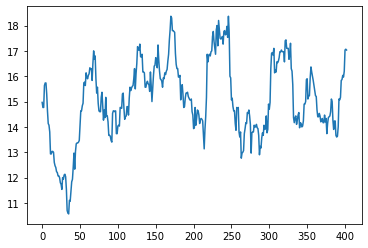

In [3]:
from matplotlib import pyplot as plt
import numpy as np
x = [17.0, 24.0, 8.0, 9.0, 10.0, 21.0, 29.0, 24.0, 11.0, 15.0, 47.0, 10.0, 24.0, 7.0, 10.0, 20.0, 13.0, 10.0, 17.0, 9.0, 12.0, 9.0, 13.0, 16.0, 10.0, 14.0, 10.0, 11.0, 9.0, 10.0, 11.0, 24.0, 34.0, 12.0, 10.0, 8.0, 9.0, 9.0, 9.0, 7.0, 21.0, 10.0, 27.0, 7.0, 9.0, 8.0, 9.0, 8.0, 12.0, 8.0, 8.0, 9.0, 11.0, 10.0, 8.0, 8.0, 24.0, 9.0, 14.0, 11.0, 8.0, 9.0, 9.0, 9.0, 9.0, 24.0, 8.0, 21.0, 20.0, 10.0, 35.0, 27.0, 8.0, 28.0, 18.0, 9.0, 9.0, 9.0, 14.0, 26.0, 25.0, 9.0, 17.0, 13.0, 32.0, 9.0, 20.0, 24.0, 9.0, 9.0, 12.0, 11.0, 16.0, 7.0, 10.0, 10.0, 28.0, 36.0, 10.0, 14.0, 8.0, 10.0, 15.0, 9.0, 9.0, 8.0, 9.0, 26.0, 20.0, 9.0, 9.0, 21.0, 8.0, 37.0, 10.0, 9.0, 13.0, 8.0, 9.0, 8.0, 7.0, 9.0, 50.0, 10.0, 10.0, 9.0, 29.0, 9.0, 10.0, 23.0, 9.0, 9.0, 37.0, 9.0, 8.0, 25.0, 10.0, 8.0, 7.0, 12.0, 10.0, 32.0, 8.0, 27.0, 30.0, 22.0, 9.0, 11.0, 11.0, 9.0, 15.0, 21.0, 26.0, 28.0, 22.0, 29.0, 25.0, 9.0, 17.0, 8.0, 9.0, 12.0, 16.0, 9.0, 7.0, 8.0, 10.0, 13.0, 9.0, 9.0, 9.0, 24.0, 31.0, 11.0, 11.0, 37.0, 25.0, 22.0, 12.0, 18.0, 10.0, 14.0, 53.0, 10.0, 9.0, 20.0, 24.0, 7.0, 10.0, 19.0, 8.0, 19.0, 14.0, 13.0, 9.0, 18.0, 18.0, 30.0, 21.0, 25.0, 7.0, 9.0, 31.0, 10.0, 10.0, 12.0, 12.0, 17.0, 12.0, 8.0, 10.0, 16.0, 24.0, 26.0, 11.0, 8.0, 9.0, 8.0, 20.0, 25.0, 8.0, 20.0, 9.0, 11.0, 7.0, 18.0, 19.0, 15.0, 17.0, 9.0, 8.0, 33.0, 10.0, 18.0, 20.0, 11.0, 7.0, 7.0, 17.0, 9.0, 9.0, 14.0, 8.0, 9.0, 34.0, 23.0, 32.0, 59.0, 11.0, 33.0, 9.0, 18.0, 14.0, 12.0, 24.0, 24.0, 7.0, 8.0, 9.0, 38.0, 13.0, 9.0, 40.0, 8.0, 9.0, 10.0, 8.0, 9.0, 8.0, 24.0, 10.0, 9.0, 9.0, 18.0, 21.0, 48.0, 13.0, 7.0, 9.0, 7.0, 11.0, 8.0, 9.0, 12.0, 9.0, 16.0, 34.0, 7.0, 10.0, 9.0, 7.0, 15.0, 9.0, 14.0, 10.0, 12.0, 28.0, 15.0, 15.0, 23.0, 23.0, 8.0, 13.0, 11.0, 11.0, 14.0, 37.0, 8.0, 9.0, 15.0, 9.0, 8.0, 12.0, 8.0, 8.0, 8.0, 11.0, 17.0, 8.0, 21.0, 13.0, 12.0, 21.0, 9.0, 11.0, 27.0, 8.0, 19.0, 45.0, 17.0, 31.0, 48.0, 31.0, 12.0, 8.0, 22.0, 8.0, 11.0, 7.0, 27.0, 8.0, 10.0, 16.0, 15.0, 8.0, 10.0, 9.0, 17.0, 8.0, 9.0, 38.0, 13.0, 11.0, 9.0, 11.0, 14.0, 13.0, 33.0, 15.0, 14.0, 15.0, 9.0, 25.0, 18.0, 10.0, 12.0, 13.0, 17.0, 10.0, 9.0, 14.0, 9.0, 12.0, 16.0, 14.0, 30.0, 9.0, 20.0, 34.0, 10.0, 14.0, 17.0, 11.0, 30.0, 24.0, 8.0, 8.0, 28.0, 9.0, 8.0, 9.0, 8.0, 9.0, 10.0, 10.0, 16.0, 10.0, 10.0, 11.0, 12.0, 9.0, 9.0, 21.0, 8.0, 18.0, 12.0, 21.0, 27.0, 35.0, 11.0, 19.0, 32.0, 8.0, 8.0, 13.0, 18.0, 8.0, 11.0, 7.0, 9.0, 20.0, 41.0, 8.0, 13.0, 30.0, 17.0, 15.0, 8.0, 18.0, 37.0, 10.0, 8.0]
N = 30
y = np.convolve(x, np.ones(N)/N, mode='valid')

plt.plot(y) 
plt.show()

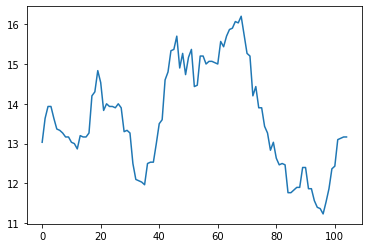

In [3]:
from matplotlib import pyplot as plt
import numpy as np
x = [13.0, 16.0, 10.0, 18.0, 19.0, 9.0, 10.0, 12.0, 9.0, 12.0, 11.0, 13.0, 9.0, 9.0, 8.0, 10.0, 9.0, 9.0, 9.0, 16.0, 29.0, 31.0, 10.0, 9.0, 10.0, 11.0, 10.0, 27.0, 11.0, 12.0, 31.0, 25.0, 10.0, 9.0, 11.0, 8.0, 8.0, 9.0, 9.0, 8.0, 10.0, 9.0, 19.0, 8.0, 8.0, 13.0, 37.0, 12.0, 25.0, 7.0, 8.0, 36.0, 8.0, 9.0, 9.0, 14.0, 7.0, 9.0, 12.0, 10.0, 8.0, 13.0, 9.0, 8.0, 9.0, 24.0, 9.0, 9.0, 23.0, 23.0, 13.0, 39.0, 25.0, 24.0, 9.0, 23.0, 13.0, 23.0, 9.0, 20.0, 14.0, 8.0, 9.0, 31.0, 9.0, 8.0, 9.0, 9.0, 11.0, 9.0, 25.0, 9.0, 17.0, 13.0, 10.0, 29.0, 8.0, 14.0, 9.0, 9.0, 11.0, 9.0, 32.0, 8.0, 9.0, 9.0, 8.0, 10.0, 15.0, 8.0, 9.0, 9.0, 8.0, 10.0, 9.0, 10.0, 11.0, 9.0, 26.0, 9.0, 9.0, 9.0, 8.0, 8.0, 9.0, 25.0, 17.0, 24.0, 24.0, 11.0, 31.0, 10.0, 33.0, 8.0]
N = 30
y = np.convolve(x, np.ones(N)/N, mode='valid')

plt.plot(y) 
plt.show()